## Import all useful libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error

from scipy.optimize import brute
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# for interactive plots
# %matplotlib notebook
plt.style.use('ggplot')

## 1. Read from data file 

In [29]:
data_path = os.path.join('../data','NY_FL_flight_demand.csv')
df = pd.read_csv(data_path)

## 2. Data Summary

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694917 entries, 0 to 694916
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   search_date          694917 non-null  object
 1   origin_airport_code  694917 non-null  object
 2   origin_city          694917 non-null  object
 3   origin_region        694917 non-null  object
 4   origin_country       694917 non-null  object
 5   dest_airport_code    694917 non-null  object
 6   destination_city     694917 non-null  object
 7   destination_region   694917 non-null  object
 8   destination_country  694917 non-null  object
 9   flight_demand        694917 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 53.0+ MB


In [4]:
"""
Pandas has parsed 'search_date' column as string not datetime, lets remedy that
"""
print("Default dtype: ",type(df['search_date'][0]))
print("Modified dtype: ",type(pd.to_datetime(df['search_date'][0])))



Default dtype:  <class 'str'>
Modified dtype:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [30]:
"""
Converting to datetime will be useful for further operations
# """
df['search_date'] = pd.to_datetime(df['search_date'])
print("Start Date: {0} \nEnd Date: {1}".format(df['search_date'].min(),df['search_date'].max()))

"""
Setting 'search_date' as index will yield great operational benefits
"""
df.set_index('search_date', drop=True, inplace=True)

Start Date: 2016-03-01 00:00:00 
End Date: 2018-03-31 00:00:00


In [6]:
"""
Lets analyze the entropy of each column 
Observations: 
1. All flights are domestic
2. Some cities (likely large) have more than one airport
"""
print("Flights originating from {}".format(pd.unique(df['origin_region'])))
print("Flights destined for {}".format(pd.unique(df['destination_region'])))

Flights originating from ['FL' 'NY']
Flights destined for ['CO' 'MA' 'NY' 'DC' 'NC' 'MI' 'MD' 'AZ' 'WA' 'CA' 'TX' 'IL' 'MN' 'PA'
 'NV' 'NJ' 'OH' 'GA' 'LA' 'TN' 'FL' 'HI']


## 3. Ascertaining patterns i.e. Temporal | Spatial

In [31]:
"""
Quick operation to create some dated categorical variables
"""
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df.reset_index(inplace=True,drop=True)

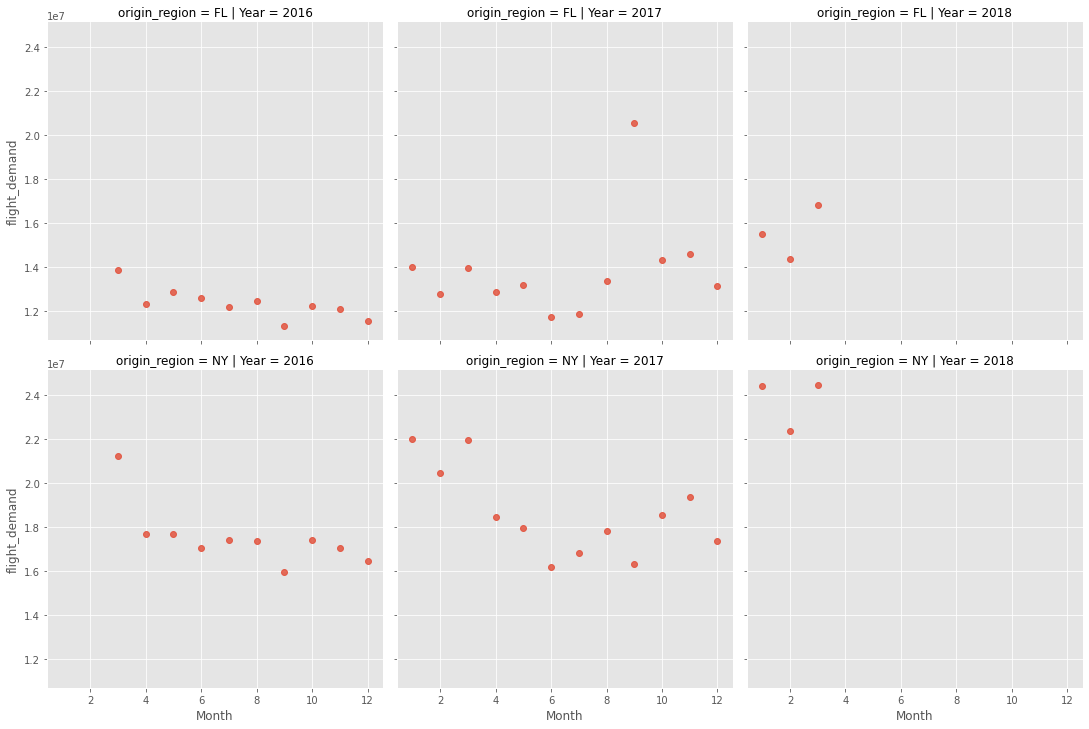

In [8]:
sns.lmplot(data=df.groupby(['origin_region','Year','Month']).sum().reset_index(),
           col='Year',row='origin_region',x='Month',y='flight_demand', fit_reg=False)
plt.show()

### 3.1 Finding popular destinations 

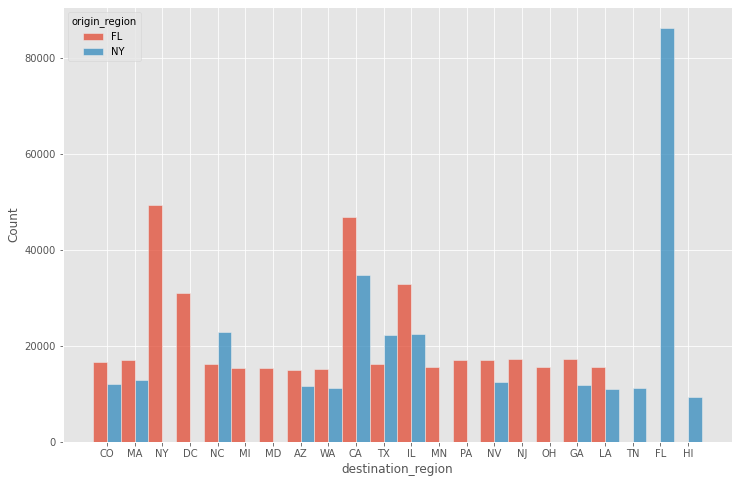

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(data = df,
             hue = 'origin_region', x = 'destination_region',
             multiple='dodge')
plt.show()

New York to Florida seems to be the most popular

###  3.2 Looking at destinations across the years

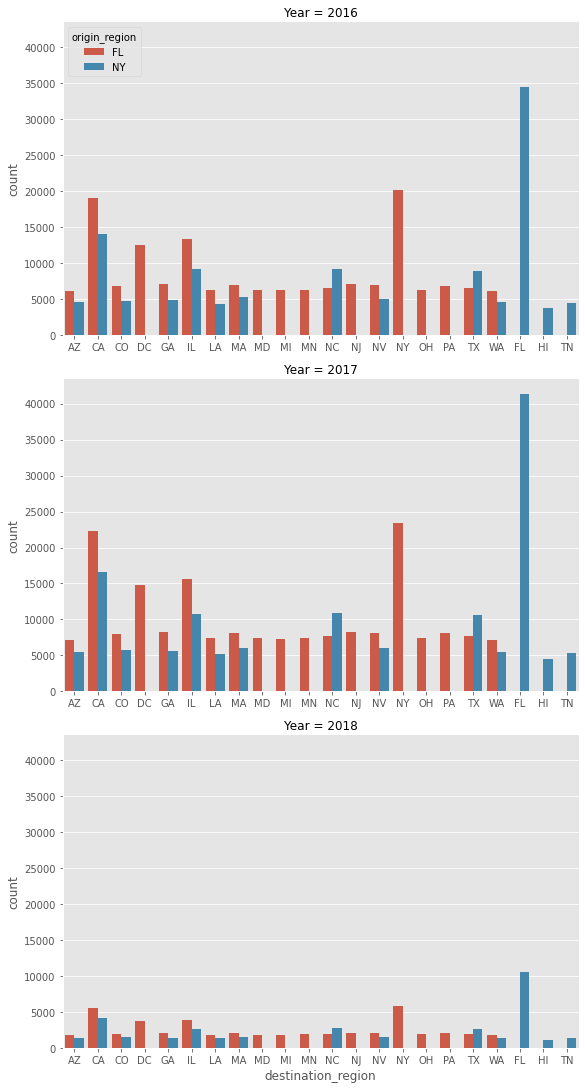

In [10]:
df['count'] = 1
temp  = df.groupby(['origin_region','Year','destination_region'])['count'].count().reset_index()


sns.catplot(x='destination_region',y='count',hue='origin_region',
           row='Year', data=temp, kind='bar', aspect=1.6,
           sharex=False, legend_out=False)
plt.show()

## 4. Reloading data and transforming 

The prior analysis has not revealed much, we will take a different approach. Firstly, we will read the data again

In [11]:
df = pd.read_csv(data_path)

In [36]:
df_pivot.head()

origin_region          FL                                                   \
destination_region     AZ     CA     CO     DC     GA     IL     LA     MA   
search_date                                                                  
2016-03-01          12036  68954  23016  34695  25650  38569  11743  38226   
2016-03-02          10944  68028  22975  34853  24794  36657   9641  36418   
2016-03-03          10769  62544  22472  32077  24007  34306   8519  33024   
2016-03-04           9427  55647  19080  28570  21969  29810   8422  28286   
2016-03-05           7356  47156  16129  22882  15228  24322   7016  23528   

origin_region                     ...     NY                              \
destination_region     MD     MI  ...     GA     HI     IL     LA     MA   
search_date                       ...                                      
2016-03-01          10321  11748  ...  34800  14404  51048  37178  13287   
2016-03-02          10144  11582  ...  33214  13819  51259  33657  12661   
2016-03-03           9304  11057  ...  30015  13018  46178  29737  11518   
2016-03-04           8479   9605  ...  24300  11360  39156  23519  10850   
2016-03-05           6762   8864  ...  19260  10736  31076  20164   7951   

origin_region                                          
destination_region     NC     NV     TN     TX     WA  
search_date                                            
2016-03-01          33331  57911  18034  51693  20292  
2016-03-02          28447  58089  17132  47574  20632  
2016-03-03          27492  51061  14933  45995  17822  
2016-03-04          24039  43296  11616  38340  15356  
2016-03-05          18734  34984   9032  28684  13062  

[5 rows x 33 columns]

### 4.1 Lets look at autocorrelations 

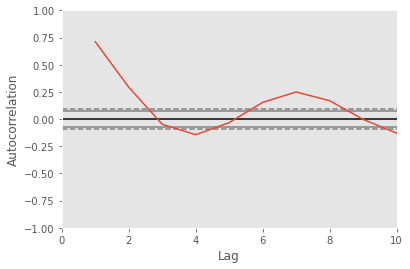

In [60]:
# Invoking the autocorrelation function and plot built-in pandas
# fig,ax = plt.figure(figsize=(10,8))
ax=pd.plotting.autocorrelation_plot(df_pivot[('FL','CA')])
ax.set_xlim([0,10])
plt.show()

### 4.2 Find optimal parameters (d,p,q) for fitting ARIMA model  

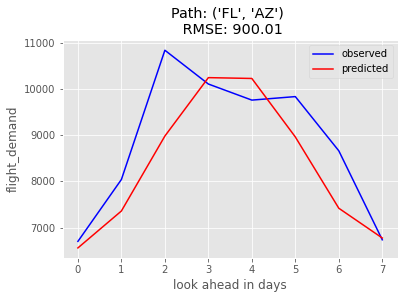

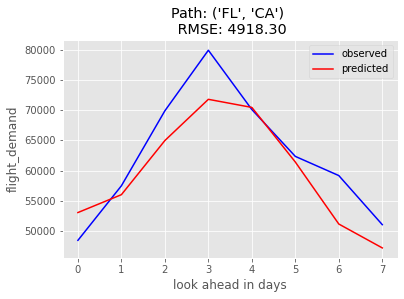

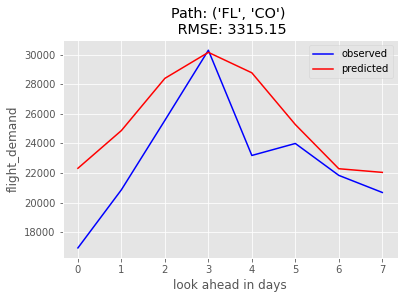

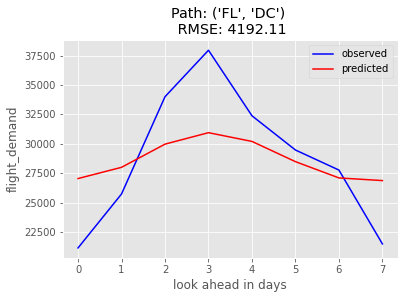

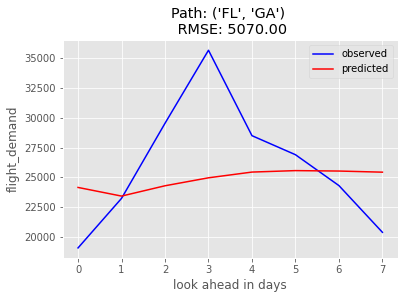

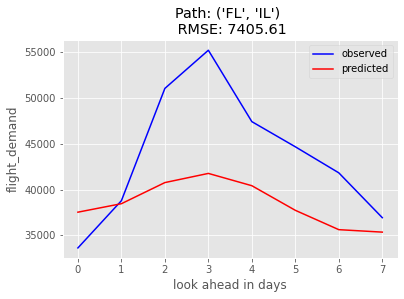

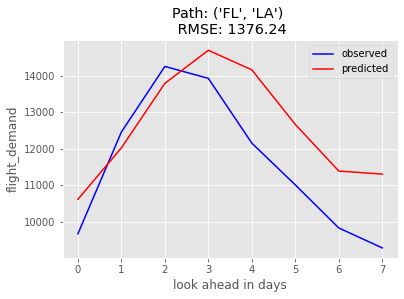

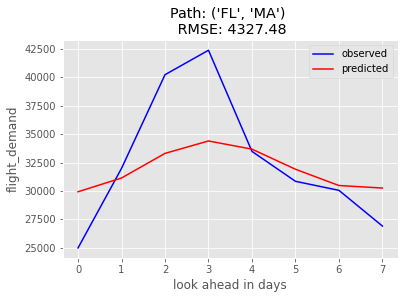

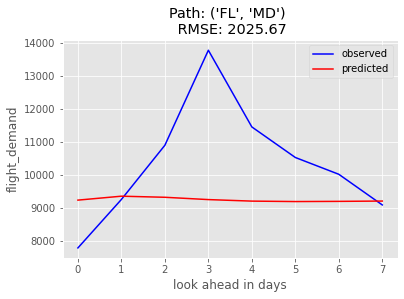

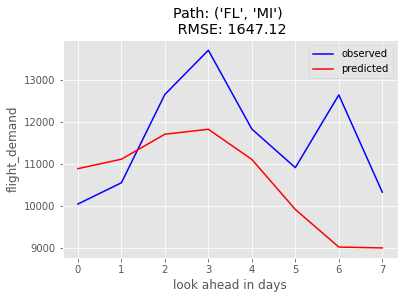

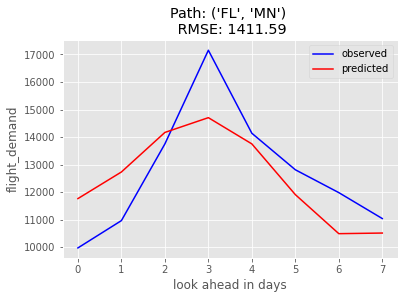

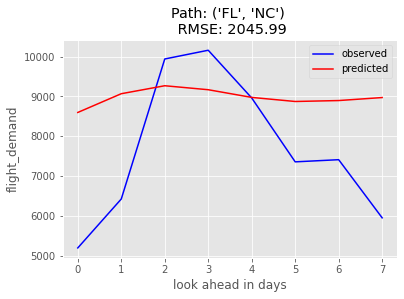

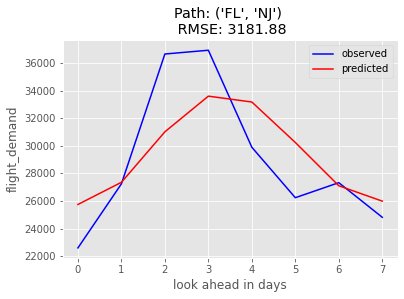

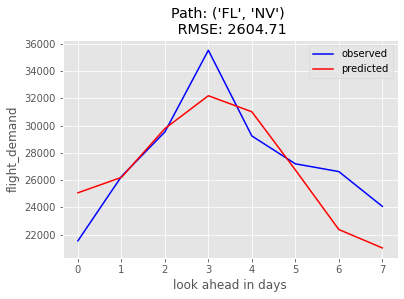

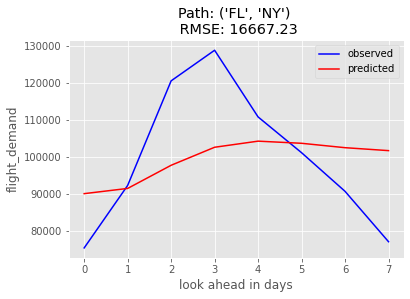

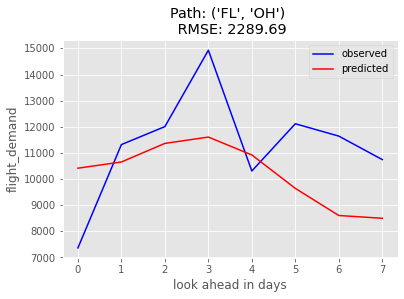

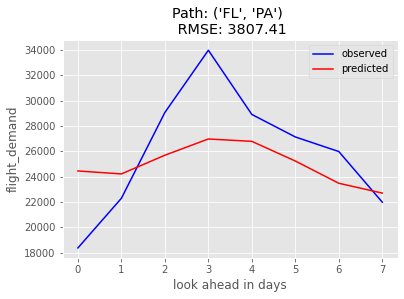

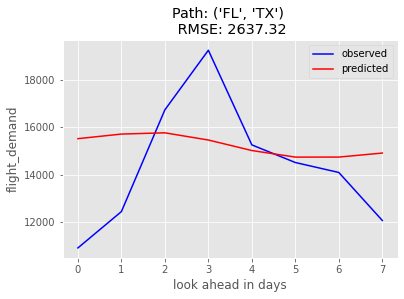

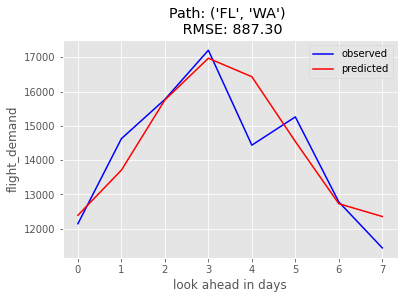

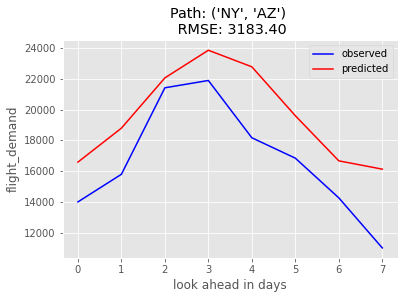

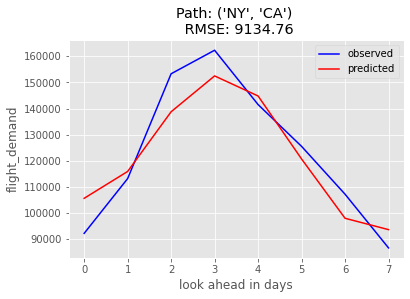

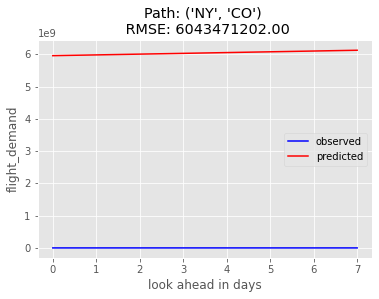

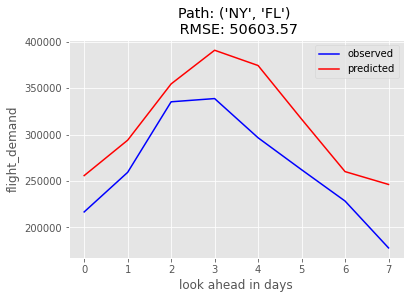

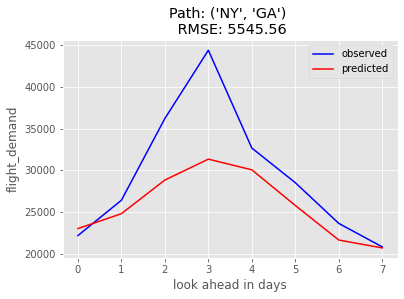

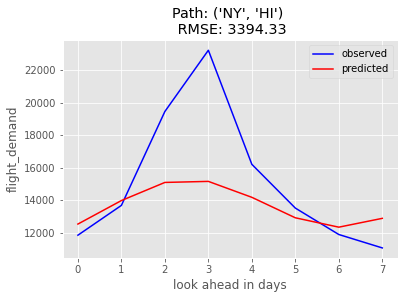

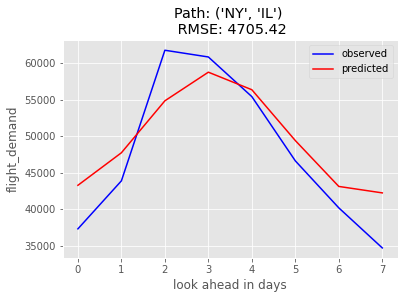

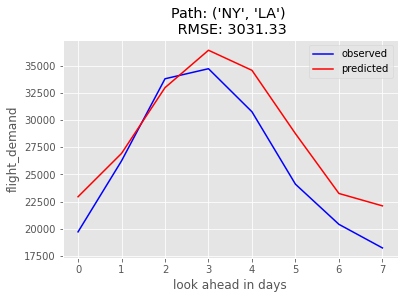

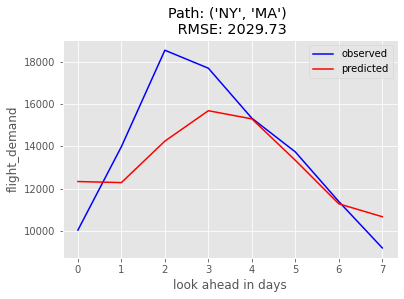

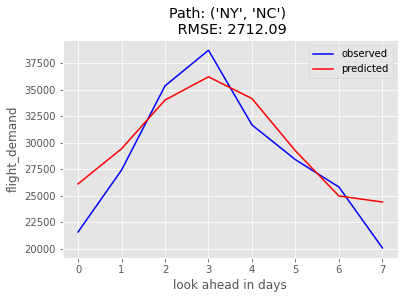

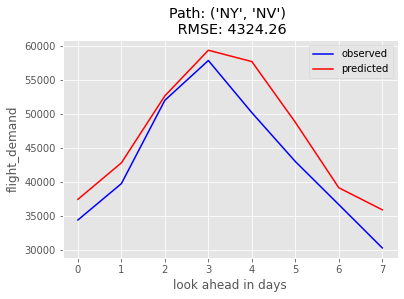

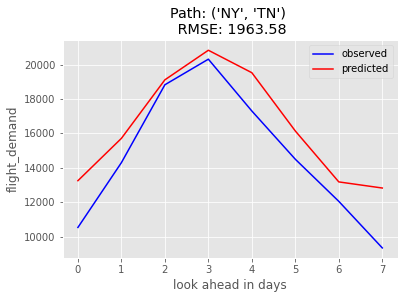

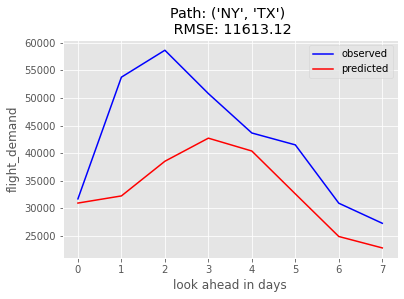

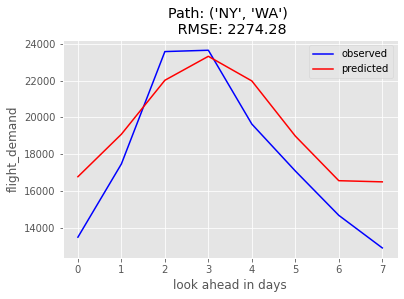

In [147]:
def data_split(column, train_size=.95):
    y = df_pivot[column].to_list()
    idx = int(len(y)*train_size)
    train, test = y[0:idx], y[idx:]
    return train, test

def ts_fit(order, *params):
    train = params[0]
    model_fit = ARIMA(endog=train, order=order).fit()
    return model_fit.aic


search_grid = (slice(0, 4, 1), slice(0, 3, 1), slice(0, 4, 1))
optimal_params = {}
for col in df_pivot:
    train, test = data_split(col, train_size=0.99)
    result = brute(ts_fit, ranges=search_grid, args=[train], finish=None)
    optimal_params[col]=tuple(result.astype(int))
    
    # Use optimal params to forecast model
    model = ARIMA(endog=train, order=optimal_params[col])
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
#     print(predictions)
    rmse = sqrt(mean_squared_error(test, predictions))
#     print('Test RMSE: %.3f' % rmse)
    
    # plot forecasts against actual outcomes
    plt.title("Path: {0} \n RMSE: {1:.2f}".format(col,rmse))
    plt.plot(test, color='blue', label='observed')
    plt.plot(predictions, color='red', label='predicted')
    plt.ylabel('flight_demand')
    plt.xlabel('look ahead in days')
    plt.legend()
    plt.show()

>_Remark_: There appears to be some interplay between choosing the optimal parameters <br> 
for flights originating from **FL** and those from **NY** : 
>1. Flights from **FL** seem to fit better when parameters ranged $d:[0,1], p:[2,3], q:3$
>2. While flights from **NY** fit better when parameters ranged $d:1, p:2, q:2$

In [142]:
optimal_params

{('FL', 'AZ'): (2, 1, 2),
 ('FL', 'CA'): (2, 0, 2),
 ('FL', 'CO'): (2, 1, 2),
 ('FL', 'DC'): (2, 0, 2),
 ('FL', 'GA'): (2, 0, 2),
 ('FL', 'IL'): (2, 0, 2),
 ('FL', 'LA'): (2, 1, 2),
 ('FL', 'MA'): (2, 0, 2),
 ('FL', 'MD'): (2, 0, 2),
 ('FL', 'MI'): (2, 0, 2),
 ('FL', 'MN'): (2, 0, 2),
 ('FL', 'NC'): (2, 0, 2),
 ('FL', 'NJ'): (2, 1, 2),
 ('FL', 'NV'): (2, 1, 2),
 ('FL', 'NY'): (2, 0, 2),
 ('FL', 'OH'): (2, 1, 2),
 ('FL', 'PA'): (2, 0, 2),
 ('FL', 'TX'): (2, 0, 2),
 ('FL', 'WA'): (2, 1, 2),
 ('NY', 'AZ'): (2, 1, 2),
 ('NY', 'CA'): (2, 1, 2),
 ('NY', 'CO'): (2, 1, 2),
 ('NY', 'FL'): (2, 1, 2),
 ('NY', 'GA'): (2, 1, 2),
 ('NY', 'HI'): (2, 1, 2),
 ('NY', 'IL'): (2, 1, 2),
 ('NY', 'LA'): (2, 1, 2),
 ('NY', 'MA'): (2, 1, 2),
 ('NY', 'NC'): (2, 1, 2),
 ('NY', 'NV'): (2, 1, 2),
 ('NY', 'TN'): (2, 1, 2),
 ('NY', 'TX'): (2, 1, 2),
 ('NY', 'WA'): (2, 1, 2)}

In [148]:
optimal_params

{('FL', 'AZ'): (3, 0, 3),
 ('FL', 'CA'): (3, 0, 3),
 ('FL', 'CO'): (3, 1, 3),
 ('FL', 'DC'): (3, 1, 3),
 ('FL', 'GA'): (3, 1, 3),
 ('FL', 'IL'): (3, 1, 3),
 ('FL', 'LA'): (3, 1, 3),
 ('FL', 'MA'): (3, 1, 3),
 ('FL', 'MD'): (2, 1, 3),
 ('FL', 'MI'): (3, 1, 3),
 ('FL', 'MN'): (3, 1, 3),
 ('FL', 'NC'): (3, 1, 3),
 ('FL', 'NJ'): (3, 1, 3),
 ('FL', 'NV'): (3, 0, 3),
 ('FL', 'NY'): (2, 1, 3),
 ('FL', 'OH'): (3, 1, 3),
 ('FL', 'PA'): (3, 1, 3),
 ('FL', 'TX'): (3, 1, 3),
 ('FL', 'WA'): (3, 1, 3),
 ('NY', 'AZ'): (3, 0, 3),
 ('NY', 'CA'): (3, 0, 3),
 ('NY', 'CO'): (3, 2, 2),
 ('NY', 'FL'): (3, 0, 3),
 ('NY', 'GA'): (3, 0, 3),
 ('NY', 'HI'): (3, 1, 3),
 ('NY', 'IL'): (3, 1, 3),
 ('NY', 'LA'): (3, 0, 3),
 ('NY', 'MA'): (3, 0, 3),
 ('NY', 'NC'): (3, 0, 3),
 ('NY', 'NV'): (3, 0, 3),
 ('NY', 'TN'): (3, 0, 3),
 ('NY', 'TX'): (3, 0, 3),
 ('NY', 'WA'): (3, 0, 3)}